other statistics to add (per newspaper):
- ✓ number of issues 
- ✓ number of pages
- ✓ number of content items
- ✓ number of images
- ✓ number of tokens

## Imports

In [100]:
!kubectl get pods

NAME                                                            READY   STATUS    RESTARTS   AGE
dask-scheduler-impresso-evenizer-language-nb-68dcddc794-9ncgd   1/1     Running   0          153m
dask-workers-impresso-evenizer-language-nb-75f6b9bc4d-jzp84     1/1     Running   0          153m
dask-workers-impresso-evenizer-language-nb-75f6b9bc4d-mxdkt     1/1     Running   0          153m


In [1]:
import os, sys
sys.path.append("../")
import pandas as pd
import json
from dask import bag as db
from dask_k8 import DaskCluster
from dask.distributed import Client
from impresso_commons.utils.s3 import IMPRESSO_STORAGEOPT, fixed_s3fs_glob
from impresso_commons.utils.s3 import alternative_read_text
from impresso_commons.utils.kube import (make_scheduler_configuration,
                                         make_worker_configuration)
from sanity_check.contents.s3_data import list_files_rebuilt, list_pages

## Set up dask k8 cluster

In [2]:
cluster = DaskCluster(
    namespace="dhlab",
    cluster_id="impresso-sanitycheck",
    scheduler_pod_spec=make_scheduler_configuration(),
    worker_pod_spec=make_worker_configuration(
        docker_image="ic-registry.epfl.ch/dhlab/impresso_pycommons:v1",
        memory="1G"
    )
)

In [18]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impr

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268,

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, 

In [3]:
cluster.create()
cluster.scale(100, blocking=False)

Scheduler: tcp://10.90.47.26:19699
Dashboard: http://10.90.47.26:24947


In [4]:
dask_client = cluster.make_dask_client()

In [7]:
dask_client

Client Scheduler: tcp://10.90.47.26:19699 Dashboard: http://10.90.47.26:8787/status,Cluster Workers: 46 Cores: 46 Memory: 46.00 GB


In [110]:
versions = dask_client.get_versions(check=True)

## Gather data for stats from rebuilt

In [13]:
# rebuilt_bucket = "s3://canonical-rebuilt-release"

rebuilt_bucket = "s3://canonical-rebuilt-release-evenized-light"

In [14]:
rebuilt_files = fixed_s3fs_glob(f'{rebuilt_bucket}/*.bz2')

In [15]:
len(rebuilt_files)

2197

In [21]:
# rebuilt_files = list_files_rebuilt(rebuilt_bucket)

Fetching list of newspapers from s3://canonical-rebuilt-release
canonical-rebuilt-release contains 76 newspapers
s3://canonical-rebuilt-release contains 3040 .bz2 files


In [17]:
contentitems_df = db.from_sequence(
    rebuilt_files,
    partition_size=2
).map(
    alternative_read_text, IMPRESSO_STORAGEOPT
).flatten().map(
    json.loads
).map(
    lambda i: {
        "id": i['id'],
        "type": i['tp'],
        "year": int(i['id'].split('-')[1]),
        "newspaper": i['id'].split('-')[0],
        "n_tokens": len(i['ft'].split()) if "ft" in i and isinstance(i['ft'], str) else None,
        # "title_length": len(i['t']) if "t" in i else None
    }
).to_dataframe(meta={
    "id": str,
    "type": str,
    "year": int,
    "newspaper": str,
    "n_tokens": object,
    # "title_length": object
}).set_index('id').persist()

ImportError: cannot import name 'Series' from 'pandas.core.series' (/opt/conda/lib/python3.7/site-packages/pandas/core/series.py)

In [35]:
ci_grouped = contentitems_df.groupby(
    by=['newspaper', 'year']
).size().compute()

In [36]:
df = pd.DataFrame(ci_grouped)
df.reset_index(inplace=True)
df["id"] = df.apply(lambda x: f"{x.newspaper}-{x.year}", axis=1)
df.set_index('id', inplace=True)
df.columns = ['newspaper', 'year', 'count']

In [37]:
# df[['count']].to_csv('../../impresso-processing/data/contentitems_stats.csv')
df[['count']].to_csv('../../impresso-processing/data/evenized-light__stats.csv')

In [38]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impr

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-pack

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent ca

## Gather data for stats from evenized (full/light)

In [26]:
dask_client

Client Scheduler: tcp://10.90.47.21:18273 Dashboard: http://10.90.47.21:8787/status,Cluster Workers: 20 Cores: 20 Memory: 200.00 GB


In [23]:
s3_evenized_full = "s3://evenized-rebuilt-full-nov-release/*bz2"
s3_evenized_light = "s3://evenized-rebuilt-light-nov-release/*bz2"

### Evenized light

In [32]:
! s3cmd ls s3://evenized-rebuilt-light-nov-release

2019-10-25 11:03  11209875   s3://evenized-rebuilt-light-nov-release/0000.jsonl.bz2
2019-10-25 11:02  11444951   s3://evenized-rebuilt-light-nov-release/0001.jsonl.bz2
2019-10-25 11:02  11969218   s3://evenized-rebuilt-light-nov-release/0002.jsonl.bz2
2019-10-25 11:03  11553605   s3://evenized-rebuilt-light-nov-release/0003.jsonl.bz2
2019-10-25 11:03  11563398   s3://evenized-rebuilt-light-nov-release/0004.jsonl.bz2
2019-10-25 11:04  11345226   s3://evenized-rebuilt-light-nov-release/0005.jsonl.bz2
2019-10-25 11:04  11527184   s3://evenized-rebuilt-light-nov-release/0006.jsonl.bz2
2019-10-25 11:03  11400794   s3://evenized-rebuilt-light-nov-release/0007.jsonl.bz2
2019-10-25 11:03  11448918   s3://evenized-rebuilt-light-nov-release/0008.jsonl.bz2
2019-10-25 11:03  11662964   s3://evenized-rebuilt-light-nov-release/0009.jsonl.bz2
2019-10-25 11:04  11392327   s3://evenized-rebuilt-light-nov-release/0010.jsonl.bz2
2019-10-25 11:06  11508031   s3://evenized-rebuilt-light-nov-release/0011.js

2019-10-25 11:06  11801859   s3://evenized-rebuilt-light-nov-release/0434.jsonl.bz2
2019-10-25 11:02  11755796   s3://evenized-rebuilt-light-nov-release/0435.jsonl.bz2
2019-10-25 11:02  11435718   s3://evenized-rebuilt-light-nov-release/0436.jsonl.bz2
2019-10-25 11:03  11421651   s3://evenized-rebuilt-light-nov-release/0437.jsonl.bz2
2019-10-25 11:03  11464353   s3://evenized-rebuilt-light-nov-release/0438.jsonl.bz2
2019-10-25 11:03  11186180   s3://evenized-rebuilt-light-nov-release/0439.jsonl.bz2
2019-10-25 11:04  11241207   s3://evenized-rebuilt-light-nov-release/0440.jsonl.bz2
2019-10-25 11:04  11250973   s3://evenized-rebuilt-light-nov-release/0441.jsonl.bz2
2019-10-25 11:02  11253042   s3://evenized-rebuilt-light-nov-release/0442.jsonl.bz2
2019-10-25 11:04  11687571   s3://evenized-rebuilt-light-nov-release/0443.jsonl.bz2
2019-10-25 11:05  11766099   s3://evenized-rebuilt-light-nov-release/0444.jsonl.bz2
2019-10-25 11:05  11550534   s3://evenized-rebuilt-light-nov-release/0445.js

2019-10-25 11:06  11513400   s3://evenized-rebuilt-light-nov-release/0911.jsonl.bz2
2019-10-25 11:05  11694947   s3://evenized-rebuilt-light-nov-release/0912.jsonl.bz2
2019-10-25 11:05  11481461   s3://evenized-rebuilt-light-nov-release/0913.jsonl.bz2
2019-10-25 11:06  11560135   s3://evenized-rebuilt-light-nov-release/0914.jsonl.bz2
2019-10-25 11:02  11322434   s3://evenized-rebuilt-light-nov-release/0915.jsonl.bz2
2019-10-25 11:02  11480976   s3://evenized-rebuilt-light-nov-release/0916.jsonl.bz2
2019-10-25 11:02  11686829   s3://evenized-rebuilt-light-nov-release/0917.jsonl.bz2
2019-10-25 11:02  11665312   s3://evenized-rebuilt-light-nov-release/0918.jsonl.bz2
2019-10-25 11:03  11641982   s3://evenized-rebuilt-light-nov-release/0919.jsonl.bz2
2019-10-25 11:04  11363950   s3://evenized-rebuilt-light-nov-release/0920.jsonl.bz2
2019-10-25 11:04  11586086   s3://evenized-rebuilt-light-nov-release/0921.jsonl.bz2
2019-10-25 11:04  11786036   s3://evenized-rebuilt-light-nov-release/0922.js

2019-10-25 11:06  11770519   s3://evenized-rebuilt-light-nov-release/1318.jsonl.bz2
2019-10-25 11:06  11667581   s3://evenized-rebuilt-light-nov-release/1319.jsonl.bz2
2019-10-25 11:02  11788550   s3://evenized-rebuilt-light-nov-release/1320.jsonl.bz2
2019-10-25 11:02  11542014   s3://evenized-rebuilt-light-nov-release/1321.jsonl.bz2
2019-10-25 11:03  11616968   s3://evenized-rebuilt-light-nov-release/1322.jsonl.bz2
2019-10-25 11:03  11194643   s3://evenized-rebuilt-light-nov-release/1323.jsonl.bz2
2019-10-25 11:03  11403679   s3://evenized-rebuilt-light-nov-release/1324.jsonl.bz2
2019-10-25 11:04  11609168   s3://evenized-rebuilt-light-nov-release/1325.jsonl.bz2
2019-10-25 11:05  11615905   s3://evenized-rebuilt-light-nov-release/1326.jsonl.bz2
2019-10-25 11:03  11408412   s3://evenized-rebuilt-light-nov-release/1327.jsonl.bz2
2019-10-25 11:04  11552470   s3://evenized-rebuilt-light-nov-release/1328.jsonl.bz2
2019-10-25 11:03  11251841   s3://evenized-rebuilt-light-nov-release/1329.js

2019-10-25 11:03   5718734   s3://evenized-rebuilt-light-nov-release/1772.jsonl.bz2
2019-10-25 11:03   5771587   s3://evenized-rebuilt-light-nov-release/1773.jsonl.bz2
2019-10-25 11:03   5698313   s3://evenized-rebuilt-light-nov-release/1774.jsonl.bz2
2019-10-25 11:04   5896350   s3://evenized-rebuilt-light-nov-release/1775.jsonl.bz2
2019-10-25 11:04   5679799   s3://evenized-rebuilt-light-nov-release/1776.jsonl.bz2
2019-10-25 11:03   5778671   s3://evenized-rebuilt-light-nov-release/1777.jsonl.bz2
2019-10-25 11:04   5856605   s3://evenized-rebuilt-light-nov-release/1778.jsonl.bz2
2019-10-25 11:04   5889152   s3://evenized-rebuilt-light-nov-release/1779.jsonl.bz2
2019-10-25 11:05   5726349   s3://evenized-rebuilt-light-nov-release/1780.jsonl.bz2
2019-10-25 11:06   5700345   s3://evenized-rebuilt-light-nov-release/1781.jsonl.bz2
2019-10-25 11:05   5753982   s3://evenized-rebuilt-light-nov-release/1782.jsonl.bz2
2019-10-25 11:06   5530405   s3://evenized-rebuilt-light-nov-release/1783.js

2019-10-25 11:02   5592795   s3://evenized-rebuilt-light-nov-release/2252.jsonl.bz2
2019-10-25 11:03   5970908   s3://evenized-rebuilt-light-nov-release/2253.jsonl.bz2
2019-10-25 11:03   5894939   s3://evenized-rebuilt-light-nov-release/2254.jsonl.bz2
2019-10-25 11:04   5646483   s3://evenized-rebuilt-light-nov-release/2255.jsonl.bz2
2019-10-25 11:04   5788810   s3://evenized-rebuilt-light-nov-release/2256.jsonl.bz2
2019-10-25 11:03   5785425   s3://evenized-rebuilt-light-nov-release/2257.jsonl.bz2
2019-10-25 11:05   5615206   s3://evenized-rebuilt-light-nov-release/2258.jsonl.bz2
2019-10-25 11:03   5614468   s3://evenized-rebuilt-light-nov-release/2259.jsonl.bz2
2019-10-25 11:04   5863528   s3://evenized-rebuilt-light-nov-release/2260.jsonl.bz2
2019-10-25 11:06   5607335   s3://evenized-rebuilt-light-nov-release/2261.jsonl.bz2
2019-10-25 11:05   5937168   s3://evenized-rebuilt-light-nov-release/2262.jsonl.bz2
2019-10-25 11:06   5599444   s3://evenized-rebuilt-light-nov-release/2263.js

2019-10-25 11:04   5757854   s3://evenized-rebuilt-light-nov-release/2737.jsonl.bz2
2019-10-25 11:04   5863450   s3://evenized-rebuilt-light-nov-release/2738.jsonl.bz2
2019-10-25 11:04   5788532   s3://evenized-rebuilt-light-nov-release/2739.jsonl.bz2
2019-10-25 11:03   5708927   s3://evenized-rebuilt-light-nov-release/2740.jsonl.bz2
2019-10-25 11:06   5895138   s3://evenized-rebuilt-light-nov-release/2741.jsonl.bz2
2019-10-25 11:05   5749063   s3://evenized-rebuilt-light-nov-release/2742.jsonl.bz2
2019-10-25 11:05   5693154   s3://evenized-rebuilt-light-nov-release/2743.jsonl.bz2
2019-10-25 11:06   5774184   s3://evenized-rebuilt-light-nov-release/2744.jsonl.bz2
2019-10-25 11:03   5973379   s3://evenized-rebuilt-light-nov-release/2745.jsonl.bz2
2019-10-25 11:02   5809422   s3://evenized-rebuilt-light-nov-release/2746.jsonl.bz2
2019-10-25 11:02   5708370   s3://evenized-rebuilt-light-nov-release/2747.jsonl.bz2
2019-10-25 11:03   5783924   s3://evenized-rebuilt-light-nov-release/2748.js

2019-10-25 11:05   5884549   s3://evenized-rebuilt-light-nov-release/3252.jsonl.bz2
2019-10-25 11:06   5740366   s3://evenized-rebuilt-light-nov-release/3253.jsonl.bz2
2019-10-25 11:06   5610010   s3://evenized-rebuilt-light-nov-release/3254.jsonl.bz2
2019-10-25 11:02   5472504   s3://evenized-rebuilt-light-nov-release/3255.jsonl.bz2
2019-10-25 11:02   5821151   s3://evenized-rebuilt-light-nov-release/3256.jsonl.bz2
2019-10-25 11:02   5884016   s3://evenized-rebuilt-light-nov-release/3257.jsonl.bz2
2019-10-25 11:02   6058868   s3://evenized-rebuilt-light-nov-release/3258.jsonl.bz2
2019-10-25 11:03   5761453   s3://evenized-rebuilt-light-nov-release/3259.jsonl.bz2
2019-10-25 11:04   5691746   s3://evenized-rebuilt-light-nov-release/3260.jsonl.bz2
2019-10-25 11:04   5813069   s3://evenized-rebuilt-light-nov-release/3261.jsonl.bz2
2019-10-25 11:04   5723799   s3://evenized-rebuilt-light-nov-release/3262.jsonl.bz2
2019-10-25 11:04   5864063   s3://evenized-rebuilt-light-nov-release/3263.js

In [30]:
evenized_files = fixed_s3fs_glob(s3_evenized_light)

In [31]:
len(evenized_files)

3375

In [34]:
dask_client.get_futures_error(evenized_light_data)

(<function distributed.worker.execute_task(task)>,
 ((<function dask.bag.core.reify(seq)>,
   (<function dask.bag.core.map_chunk(f, iters, iter_kwarg_keys=None, kwargs=None)>,
    <function __main__.<lambda>(i)>,
    [(<function dask.bag.core.map_chunk(f, iters, iter_kwarg_keys=None, kwargs=None)>,
      <function json.loads(s, *, encoding=None, cls=None, object_hook=None, parse_float=None, parse_int=None, parse_constant=None, object_pairs_hook=None, **kw)>,
      [(<function toolz.itertoolz.concat(seqs)>,
        (<function dask.bag.core.map_chunk(f, iters, iter_kwarg_keys=None, kwargs=None)>,
         <function impresso_commons.utils.s3.alternative_read_text(s3_key, s3_credentials)>,
         [['s3://evenized-rebuilt-light-nov-release/1120.jsonl.bz2',
           's3://evenized-rebuilt-light-nov-release/1121.jsonl.bz2',
           's3://evenized-rebuilt-light-nov-release/1122.jsonl.bz2',
           's3://evenized-rebuilt-light-nov-release/1123.jsonl.bz2',
           's3://evenized-reb

In [35]:
dask_client.cancel(evenized_light_data)

In [36]:
evenized_light_data = db.from_sequence(
    evenized_files,
    partition_size=10
).map(
    alternative_read_text, IMPRESSO_STORAGEOPT
).flatten().map(
    json.loads
).map(
    lambda i: {
        "id": i['id'],
        "year": i['id'].split('-')[1],
        "newspaper": i['id'].split('-')[0],
        "type": i['tp'],
        "n_tokens": len(i['ft'].split()) if "ft" in i else None,
        "title_length": len(i['t']) if "t" in i and i['t'] else None
    }
).persist()

In [108]:
evenized_light_data.take(1)

({'id': 'EXP-1870-09-14-a-i0044',
  'year': '1870',
  'newspaper': 'EXP',
  'type': 'ar',
  'n_tokens': 55},)

In [37]:
evenized_light_df = evenized_light_data.to_dataframe(meta={
    "id": str,
    "year": str,
    "newspaper": str,
    "type": str,
    "n_tokens": object,
    "title_length": object
}).set_index('id').persist()

In [41]:
evenized_light_df.title_length.max().compute()

unique        3156.0
count     28582354.0
top              7.0
freq       4201003.0
Name: title_length, dtype: float64

### save to s3 and read back from it

In [42]:
files = evenized_light_df.to_csv(
    "s3://impresso-stats/content-item-stats/",
    storage_options=IMPRESSO_STORAGEOPT
)

In [43]:
from dask import dataframe as ddf

test_df = ddf.read_csv(
    "s3://impresso-stats/content-item-stats/*",
    storage_options=IMPRESSO_STORAGEOPT
)

In [46]:
test_df = test_df.fillna(0).persist()

In [48]:
test_df.head()

,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,0.0
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,0.0


In [51]:
test_df = test_df.astype(
    {
        'title_length':'int64',
        'n_tokens': 'int64',
        'year': 'int64',
        'newspaper': 'str',
        'type': 'str'
    }).persist()

In [58]:
test_df.head(100)

,id,year,newspaper,type,n_tokens,title_length
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250,4
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758,0
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14,31
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349,22
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193,0
5,BDC-1839-01-20-a-i0006,1839,BDC,ar,475,0
6,BDC-1839-01-20-a-i0007,1839,BDC,ar,177,0
7,BDC-1839-01-20-a-i0008,1839,BDC,ar,590,0
8,BDC-1839-01-20-a-i0009,1839,BDC,ar,542,0
9,BDC-1839-01-20-a-i0010,1839,BDC,img,0,0


In [56]:
pd.options.display.float_format = '{:20,.2f}'.format

In [63]:
test_df[(test_df.type=='ar') & (test_df.title_length > 100)].compute().shape

(278458, 6)

In [64]:
test_df.title_length.describe().compute()

count          47,876,994.00
mean                   16.46
std                    39.22
min                     0.00
25%                     0.00
50%                    17.00
75%                    43.00
max                19,306.00
Name: title_length, dtype: float64

In [60]:
test_df[test_df.type=='ar'].title_length.describe().compute()

count          26,903,280.00
mean                   26.64
std                    42.52
min                     0.00
25%                    15.00
50%                    30.00
75%                    58.00
max                16,052.00
Name: title_length, dtype: float64

In [19]:
len(issue_ids)

47876994

In [26]:
test_df['issue_id'] = test_df.apply(
    lambda x: "-".join(x['id'].split("-")[:-1]), 
    meta=('issue_id', str),
    axis=1
)

In [27]:
test_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,BDC-1839-01-20-a
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,BDC-1839-01-20-a


In [65]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impr

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268,

### load license information

In [29]:
from sanity_check.contents.s3_data import fetch_issues

In [31]:
issue_bag = fetch_issues("s3://original-canonical-staging", compute=False)

Fetching list of newspapers from s3://original-canonical-staging
original-canonical-staging contains 78 newspapers
s3://original-canonical-staging contains 3101 .bz2 files
Fetching issue ids from 3101 .bz2 files (compute=False)


In [33]:
license_df = issue_bag.map(lambda i: {"id": i['id'], "license": i['ar']}).to_dataframe().set_index('id').persist()

In [54]:
pd_license_df = license_df.compute()

In [57]:
pd_license_df['year'] = pd_license_df.index.map(lambda idx: idx.split('-')[1])

In [69]:
pd_license_df.license.replace({'open_private': 'closed'}, inplace=True)

In [80]:
pd_license_df.groupby(
    by=['license']
).size()

license
closed         525023
open_public     79746
dtype: int64

In [71]:
license_by_year = pd_license_df.pivot_table(index='year', columns='license', values='license', aggfunc=len)

In [76]:
license_by_year.to_pickle('../../impresso-processing/data/issue_license_by_year.pkl')

In [36]:
enriched_df = test_df.join(license_df, on='issue_id').persist()

In [37]:
enriched_df.head()

,id,year,newspaper,type,n_tokens,title_length,issue_id,license
0,BDC-1839-01-20-a-i0001,1839,BDC,ar,250.0,4.0,BDC-1839-01-20-a,open_public
1,BDC-1839-01-20-a-i0002,1839,BDC,ar,758.0,NaN,BDC-1839-01-20-a,open_public
2,BDC-1839-01-20-a-i0003,1839,BDC,ar,14.0,31.0,BDC-1839-01-20-a,open_public
3,BDC-1839-01-20-a-i0004,1839,BDC,ar,349.0,22.0,BDC-1839-01-20-a,open_public
4,BDC-1839-01-20-a-i0005,1839,BDC,ar,193.0,NaN,BDC-1839-01-20-a,open_public


In [77]:
files = enriched_df.to_csv(
    "s3://impresso-stats/contentitem-license-stats/",
    storage_options=IMPRESSO_STORAGEOPT
)

In [78]:
print(len(files))

3101


In [46]:
n_tokens_closed = int(enriched_df[enriched_df.license!='open_public'].n_tokens.sum().compute())

In [45]:
n_tokens_public = int(enriched_df[enriched_df.license=='open_public'].n_tokens.sum().compute())

In [81]:
print(f"N. tokens closed: {n_tokens_closed:,}")
print(f"N. tokens open: {n_tokens_public:,}")

N. tokens closed: 12,016,488,705
N. tokens open: 572,030,104


In [52]:
imgs_by_license = enriched_df[enriched_df.type=='img'].groupby(
    by=['license']
).size().compute()

In [53]:
imgs_by_license

license
open_public       32964
open_private    3030126
closed           417732
dtype: int64

### counts by type

In [75]:
counts_by_type = test_df.groupby(
    by='type'
).size().compute()

In [76]:
counts_by_type

type
ad         16648124
ar         26903280
img         3467640
section       82143
picture           1
page         561444
ob           126437
tb            85185
w              2740
dtype: int64

In [77]:
imgs_by_nps = test_df[test_df.type=='img'].groupby(
    by=['newspaper']
).size().compute()

In [78]:
imgs_by_nps_df = pd.DataFrame({"n_images": imgs_by_nps})

In [79]:
imgs_by_nps_df

,n_images
newspaper,
BDC,1
CDV,161
CON,303
DFS,6
DLE,5347
DTT,57979
EDA,51
EXP,1041396
EZR,27


In [114]:
evenized_light_df.n_tokens.sum().compute()

12508779241.0

In [ ]:
12,508,779,241

In [115]:
n_tokens_by_np = evenized_light_df.groupby(
    by='newspaper'
).agg({'n_tokens': sum}).compute()

In [123]:
n_tokens_by_np.n_tokens = n_tokens_by_np.n_tokens.astype('int64')

In [124]:
n_tokens_by_np.head()

,n_tokens
newspaper,
BDC,57942
BLB,530239
BNN,15463632
CDV,7660997
CON,516013


In [62]:
evenizedf_ci_grouped = evenized_light_df.groupby(
    by=['newspaper', 'year']
).size().compute()

In [63]:
df = pd.DataFrame(evenizedf_ci_grouped)
df.reset_index(inplace=True)
df["id"] = df.apply(lambda x: f"{x.newspaper}-{x.year}", axis=1)
df.set_index('id', inplace=True)
df.columns = ['newspaper', 'year', 'count']
df["evenized-light"] = True

In [64]:
df[['count']].to_csv('../../impresso-processing/data/contentitems_evenized-light_stats.csv')

In [82]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client -

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268,

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versio

### Evenized full

In [30]:
evenized_files = fixed_s3fs_glob(s3_evenized_full)

In [34]:
evenized_full_data = db.from_sequence(
    evenized_files,
    partition_size=10
).map(
    alternative_read_text, IMPRESSO_STORAGEOPT
).flatten().map(
    json.loads
).map(
    lambda i: {
        "id": i['id'],
        "year": i['id'].split('-')[1],
        "newspaper": i['id'].split('-')[0]
    }
).persist()

In [49]:
dask_client.get_futures_error(evenized_full_data)

(<function distributed.worker.execute_task(task)>,
 ((<function dask.bag.core.reify(seq)>,
   (<function dask.bag.core.map_chunk(f, iters, iter_kwarg_keys=None, kwargs=None)>,
    <function __main__.<lambda>(i)>,
    [(<function dask.bag.core.map_chunk(f, iters, iter_kwarg_keys=None, kwargs=None)>,
      <function json.loads(s, *, encoding=None, cls=None, object_hook=None, parse_float=None, parse_int=None, parse_constant=None, object_pairs_hook=None, **kw)>,
      [(<function toolz.itertoolz.concat(seqs)>,
        (<function dask.bag.core.map_chunk(f, iters, iter_kwarg_keys=None, kwargs=None)>,
         <function impresso_commons.utils.s3.alternative_read_text(s3_key, s3_credentials)>,
         [['s3://evenized-rebuilt-full-nov-release/1050.jsonl.bz2',
           's3://evenized-rebuilt-full-nov-release/1051.jsonl.bz2',
           's3://evenized-rebuilt-full-nov-release/1052.jsonl.bz2',
           's3://evenized-rebuilt-full-nov-release/1053.jsonl.bz2',
           's3://evenized-rebuilt

In [50]:
dask_client.cancel(evenized_full_data)

In [ ]:
evenized_full_df = evenized_full_data.to_dataframe().set_index('id').persist()

In [ ]:
evenizedf_ci_grouped = evenized_full_df.groupby(
    by=['newspaper', 'year']
).size().compute()

In [ ]:
df = pd.DataFrame(evenizedf_ci_grouped)
df.reset_index(inplace=True)
df["id"] = df.apply(lambda x: f"{x.newspaper}-{x.year}", axis=1)
df.set_index('id', inplace=True)
df.columns = ['newspaper', 'year', 'count']
df["evenized-full"] = True

In [ ]:
df[['count']].to_csv('../../impresso-processing/data/contentitems_evenized-full_stats.csv')

## CI Stats from DB

In [9]:
dask_client

Client Scheduler: tcp://10.90.47.26:19699 Dashboard: http://10.90.47.26:8787/status,Cluster Workers: 91 Cores: 91 Memory: 91.00 GB


In [10]:
def list_content_items(db_config=None):
    if db_config:
        os.environ["IMPRESSO_DB_CONFIG"] = db_config

    config = os.environ["IMPRESSO_DB_CONFIG"]
    print(f'Connecting to MySQL DB {config}')

    #
    from impresso_db.base import engine

    with engine.connect() as db_conn:
        q = "SELECT id FROM content_items;"
        mysql_ids = db_conn.execute(q)

    ci_ids = [
        db_id[0]
        for db_id in mysql_ids
    ]
    print(f'Fetched {len(ci_ids)} content item IDs from DB')
    return ci_ids

In [11]:
ci_bag = db.from_sequence(list_content_items(db_config='dev'))

Connecting to MySQL DB dev
Fetched 47726941 content item IDs from DB


In [12]:
ci_bag.take(1)

/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/worker.py:3217: UserWarning: Large object of size 13.37 MB detected in task graph: 
  (1, ['actionfem-1927-10-15-a-i0001', 'actionfem-19 ... -i0032'], True)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


('actionfem-1927-10-15-a-i0001',)

In [21]:
ci_ddf = ci_bag.map(
    lambda ci: {'id': ci,'newspaper': ci.split('-')[0], 'year': ci.split('-')[1]}
).to_dataframe().set_index('id').persist()

In [22]:
cis_grouped = ci_ddf.groupby(
    by=['newspaper', 'year']
).size().compute()

In [23]:
df = pd.DataFrame(cis_grouped)
df.reset_index(inplace=True)
df["id"] = df.apply(lambda x: f"{x.newspaper}-{x.year}", axis=1)
df.set_index('id', inplace=True)
df.columns = ['newspaper', 'year', 'count']
df["mysql"] = True

In [25]:
df[['count']].to_csv('../../impresso-processing/data/contentitems_mysql-dev.csv')

In [26]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client -

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, 

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, 

## Basic data from DB

In [32]:
import os

def fetch_newspaper_titles(db_config=None):
    if db_config:
        os.environ["IMPRESSO_DB_CONFIG"] = db_config

    config = os.environ["IMPRESSO_DB_CONFIG"]
    print(f'Connecting to MySQL DB {config}')

    #
    from impresso_db.base import engine

    with engine.connect() as db_conn:
        q = "SELECT id,title, start_year, end_year FROM newspapers;"
        mysql_data = db_conn.execute(q)

    np_ids = [
        {
            "id": datum[0],
            "title": datum[1],
            "start_year": datum[2],
            "end_year": datum[3]
        }
        for datum in mysql_data
    ]
    print(f'Fetched {len(np_ids)} newspaper IDs from DB')
    return np_ids

In [33]:
nps = fetch_newspaper_titles(db_config='dev')

Connecting to MySQL DB dev
Fetched 81 newspaper IDs from DB


In [34]:
nps[:10]

[{'id': 'actionfem',
  'title': "L'Action féminine",
  'start_year': 1927,
  'end_year': 1940},
 {'id': 'arbeitgeber',
  'title': 'Schweizer Arbeitgeber',
  'start_year': 1906,
  'end_year': 1994},
 {'id': 'armeteufel',
  'title': 'Arme Teufel',
  'start_year': 1903,
  'end_year': 1929},
 {'id': 'avenirgdl',
  'title': "L'avenir",
  'start_year': 1868,
  'end_year': 1871},
 {'id': 'BDC',
  'title': 'Bulletin des séances de la Constituante',
  'start_year': 1839,
  'end_year': 1839},
 {'id': 'BLB',
  'title': 'Bündner Landbote',
  'start_year': 1846,
  'end_year': 1847},
 {'id': 'BNN',
  'title': 'Bündner Nachrichten',
  'start_year': 1885,
  'end_year': 1892},
 {'id': 'buergerbeamten',
  'title': 'Bürger- und Beamten-Zeitung',
  'start_year': 1898,
  'end_year': 1916},
 {'id': 'CDV',
  'title': 'Courrier du Valais',
  'start_year': 1843,
  'end_year': 1857},
 {'id': 'CON', 'title': 'La Contrée', 'start_year': 1902, 'end_year': 1903}]

In [40]:
nps_df = pd.DataFrame(nps).set_index('id')

In [41]:
nps_df = nps_df[nps_df.start_year.notnull()]

In [42]:
nps_df.head(5)

,end_year,start_year,title
id,,,
actionfem,1940.0,1927.0,L'Action féminine
arbeitgeber,1994.0,1906.0,Schweizer Arbeitgeber
armeteufel,1929.0,1903.0,Arme Teufel
avenirgdl,1871.0,1868.0,L'avenir
BDC,1839.0,1839.0,Bulletin des séances de la Constituante


In [45]:
nps_df.end_year = nps_df.end_year.astype(int)
nps_df.start_year = nps_df.start_year.astype(int)

In [46]:
nps_df.head(5)

,end_year,start_year,title
id,,,
actionfem,1940,1927,L'Action féminine
arbeitgeber,1994,1906,Schweizer Arbeitgeber
armeteufel,1929,1903,Arme Teufel
avenirgdl,1871,1868,L'avenir
BDC,1839,1839,Bulletin des séances de la Constituante


In [48]:
nps_df.index

Index(['actionfem', 'arbeitgeber', 'armeteufel', 'avenirgdl', 'BDC', 'BLB',
       'BNN', 'buergerbeamten', 'CDV', 'CON', 'courriergdl', 'deletz1893',
       'demitock', 'DFS', 'diekwochen', 'DLE', 'DTT', 'dunioun', 'DVF', 'EDA',
       'EXP', 'EZR', 'FCT', 'FZG', 'GAV', 'GAZ', 'gazgrdlux', 'GDL', 'HRV',
       'IMP', 'indeplux', 'JDF', 'JDG', 'JDV', 'kommmit', 'LAB',
       'landwortbild', 'LBP', 'LCE', 'LCG', 'LCR', 'LCS', 'LES', 'LLE', 'LLS',
       'LNF', 'LSE', 'LSR', 'LTF', 'lunion', 'luxembourg1935', 'luxland',
       'luxwort', 'luxzeit1844', 'luxzeit1858', 'LVE', 'MGS', 'NTS', 'NZG',
       'NZZ', 'obermosel', 'OIZ', 'onsjongen', 'SAX', 'schmiede', 'SDT', 'SGZ',
       'SMZ', 'SRT', 'tageblatt', 'VDR', 'VHT', 'volkfreu1869',
       'waechtersauer', 'waeschfra', 'WHD', 'ZBT'],
      dtype='object', name='id')

## Combine with issue count from CIs stats

In [49]:
ci_df = pd.read_csv('../../impresso-processing/data/contentitems_stats.csv')

In [50]:
ci_df['newspaper_id'] = ci_df.id.map(lambda i: i.split('-')[0])

In [51]:
ci_df['year'] = ci_df.id.map(lambda i: i.split('-')[1])

In [52]:
ci_df.head()

,id,count,newspaper_id,year
0,BDC-1839,146,BDC,1839
1,BLB-1845,2,BLB,1845
2,BLB-1846,172,BLB,1846
3,BLB-1847,255,BLB,1847
4,BNN-1885,47,BNN,1885


In [53]:
ci_df.set_index('id', drop=False, inplace=True)

In [54]:
df = ci_df.groupby('newspaper_id').agg({'count':sum})

In [63]:
df.columns = ['n_issues']

In [56]:
df.head(5)

,n_issues
newspaper_id,
BDC,146
BLB,429
BNN,50500
CDV,16939
CON,2842


In [57]:
df.columns = ['n_issues']

In [64]:
stats_df = df.join(nps_df, how='inner')[['title', 'start_year', 'end_year', 'n_issues']]

In [65]:
stats_df.shape

(76, 4)

In [66]:
stats_df.head()

,title,start_year,end_year,n_issues
BDC,Bulletin des séances de la Constituante,1839,1839,146
BLB,Bündner Landbote,1846,1847,429
BNN,Bündner Nachrichten,1885,1892,50500
CDV,Courrier du Valais,1843,1857,16939
CON,La Contrée,1902,1903,2842


In [61]:
set(df.index).difference(stats_df.index)

set()

## Gather pages count per canonical issue

In [27]:
from sanity_check.contents.s3_data import fetch_issues

In [28]:
canonical_bucket_name = 's3://original-canonical-staging'

In [29]:
s3_canonical_issues = fetch_issues(
        canonical_bucket_name,
        compute=False
    )

Fetching list of newspapers from s3://original-canonical-staging
original-canonical-staging contains 78 newspapers
s3://original-canonical-staging contains 3101 .bz2 files
Fetching issue ids from 3101 .bz2 files (compute=False)


In [30]:
pages_count_df = s3_canonical_issues.map(
    lambda i: {
        "np_id": i["id"].split('-')[0],
        "id": i['id'],
        "n_pages": len(set(i['pp']))
    }
).to_dataframe(meta={
    'np_id': str,
    'id': str,
    "n_pages": int
}).set_index('id').persist()

In [31]:
pages_count_df.head()

,np_id,n_pages
id,,
BDC-1839-01-20-a,BDC,6
BDC-1839-01-21-a,BDC,4
BDC-1839-01-23-a,BDC,4
BDC-1839-01-26-a,BDC,8
BDC-1839-01-28-a,BDC,2


In [32]:
# at the same time we can also get the issue count
# with `np_id`: len
page_count_by_np = pages_count_df.groupby(
    by='np_id'
).agg({"n_pages": sum}).compute()

## Pull it all together

In [67]:
stats_df.head()

,title,start_year,end_year,n_issues
BDC,Bulletin des séances de la Constituante,1839,1839,146
BLB,Bündner Landbote,1846,1847,429
BNN,Bündner Nachrichten,1885,1892,50500
CDV,Courrier du Valais,1843,1857,16939
CON,La Contrée,1902,1903,2842


In [68]:
stats_df.shape

(76, 4)

In [96]:
df = stats_df.join(page_count_by_np, how='inner')

In [97]:
df.shape

(75, 3)

In [87]:
test_df

,id,year,newspaper,type,n_tokens,title_length
npartitions=338,,,,,,
,object,int64,object,object,float64,float64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


In [53]:
n_tokens_by_np = test_df.groupby(
    by='newspaper'
).agg({"n_tokens": sum}).compute()

In [60]:
n_tokens_by_np.n_tokens = n_tokens_by_np.n_tokens.astype('int')

In [61]:
n_tokens_by_np.head()

,n_tokens
newspaper,
BDC,57942
BLB,530239
BNN,15463632
CDV,7660997
CON,516013


In [63]:
n_tokens_by_np.shape

(76, 1)

In [98]:
df = df.join(n_tokens_by_np, how='inner')

In [99]:
df.shape

(75, 4)

In [90]:
df.head()

,title,n_issues,n_pages,n_tokens
BDC,Bulletin des séances de la Constituante,146,96,57942
BLB,Bündner Landbote,429,430,530239
BNN,Bündner Nachrichten,50500,7674,15463632
CDV,Courrier du Valais,16939,4880,7660997
CON,La Contrée,2842,404,516013


In [100]:
df = df.join(imgs_by_nps_df, how='outer')

In [92]:
df.head()

,title,n_issues,n_pages,n_tokens,n_images
BDC,Bulletin des séances de la Constituante,146,96,57942,1
CDV,Courrier du Valais,16939,4880,7660997,161
CON,La Contrée,2842,404,516013,303
DFS,Wochenblatt für die vier löblichen Kantone Ury...,14104,7687,10531868,6
DLE,Der Landbote des freiburgischen Seebezirks,37093,1657,2781257,5347


In [101]:
df.shape

(76, 5)

In [103]:
df.head()

,title,n_issues,n_pages,n_tokens,n_images
BDC,Bulletin des séances de la Constituante,146.0,96.0,57942.0,1.0
BLB,Bündner Landbote,429.0,430.0,530239.0,NaN
BNN,Bündner Nachrichten,50500.0,7674.0,15463632.0,NaN
CDV,Courrier du Valais,16939.0,4880.0,7660997.0,161.0
CON,La Contrée,2842.0,404.0,516013.0,303.0


In [106]:
df.n_issues.sum()

47876994

In [107]:
df.n_pages.sum()

5445822

In [127]:
df.n_tokens.sum()

12508779241

In [152]:
df.n_images.sum()

3467640

In [105]:
df.to_csv('../../impresso-processing/data/newspaper_stats.csv')

In [177]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed t

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/hom

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 998, in _reconnect
    await self._close()
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/client.py", line 1268,

## Do `.md` tables

In [106]:
import tabulate
import pandas as pd

In [107]:
from tabulate import tabulate

In [71]:
df = pd.read_csv(
    #'../../impresso-processing/data/newspaper_stats.csv',
    "/home/romanell/Downloads/test-corpus-stats/newspaper_stats.csv"
)

In [72]:
df.head()

,Unnamed: 0,end_year,start_year,title,n_pages,n_issues,n_tokens,n_images
0,actionfem,1940,1927,L'Action féminine,1900,1,834001,75
1,armeteufel,1929,1903,Arme Teufel,3678,1,6072816,411
2,avenirgdl,1871,1868,L'avenir,3927,1,13103088,4
3,BDC,1839,1839,Bulletin des séances de la Constituante,96,1,57942,1
4,BLB,1847,1846,Bündner Landbote,430,1,530239,0


In [73]:
df.n_tokens = df.n_tokens.fillna(0)
df.n_issues = df.n_issues.fillna(0)
df.n_pages = df.n_pages.fillna(0)
df.n_images = df.n_images.fillna(0)

In [74]:
df.n_tokens = df.n_tokens.astype('int')
df.n_issues = df.n_issues.astype('int')
df.n_pages = df.n_pages.astype('int')
df.n_images = df.n_images.astype('int')

In [76]:
df.rename_axis({'Unnamed: 0': 'id'}, axis=1, inplace=True)

/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  """Entry point for launching an IPython kernel.


In [77]:
df.set_index('id', inplace=True)

In [93]:
df.head()

,end_year,start_year,title,n_pages,n_issues,n_tokens,n_images
id,,,,,,,
actionfem,1940,1927,L'Action féminine,1900,1,834001,75
armeteufel,1929,1903,Arme Teufel,3678,1,6072816,411
avenirgdl,1871,1868,L'avenir,3927,1,13103088,4
BDC,1839,1839,Bulletin des séances de la Constituante,96,1,57942,1
BLB,1847,1846,Bündner Landbote,430,1,530239,0


In [79]:
import tabulate

In [80]:
tabulate.tabulate_formats

['fancy_grid',
 'github',
 'grid',
 'html',
 'jira',
 'latex',
 'latex_booktabs',
 'latex_raw',
 'mediawiki',
 'moinmoin',
 'orgtbl',
 'pipe',
 'plain',
 'presto',
 'psql',
 'rst',
 'simple',
 'textile',
 'tsv',
 'youtrack']

In [81]:
#tabulate.tabulate?

In [83]:
hs = [
    'newspaper id',
    'start year',
    'end year',
    'newspaper title',
    'n. issues',
    'n. pages',
    'n. tokens', 
    'n. images'
]

In [92]:
print(tabulate.tabulate(df, tablefmt='tsv', headers=hs))

newspaper id  	  start year	  end year	newspaper title                                                             	  n. issues	  n. pages	  n. tokens	  n. images
actionfem     	        1940	      1927	L'Action féminine                                                           	       1900	         1	     834001	         75
armeteufel    	        1929	      1903	Arme Teufel                                                                 	       3678	         1	    6072816	        411
avenirgdl     	        1871	      1868	L'avenir                                                                    	       3927	         1	   13103088	          4
BDC           	        1839	      1839	Bulletin des séances de la Constituante                                     	         96	         1	      57942	          1
BLB           	        1847	      1846	Bündner Landbote                                                            	        430	         1	     530239	          0
BNN           	       

In [84]:
print(tabulate.tabulate(df, tablefmt='pipe', headers=hs))

| newspaper id   |   start year |   end year | newspaper title                                                              |   n. issues |   n. pages |   n. tokens |   n. images |
|:---------------|-------------:|-----------:|:-----------------------------------------------------------------------------|------------:|-----------:|------------:|------------:|
| actionfem      |         1940 |       1927 | L'Action féminine                                                            |        1900 |          1 |      834001 |          75 |
| armeteufel     |         1929 |       1903 | Arme Teufel                                                                  |        3678 |          1 |     6072816 |         411 |
| avenirgdl      |         1871 |       1868 | L'avenir                                                                     |        3927 |          1 |    13103088 |           4 |
| BDC            |         1839 |       1839 | Bulletin des séances de la Constituante         

## Quick plot

In [1]:
import matplotlib

In [2]:
import matplotlib.pyplot as plt

In [3]:
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rcParams['legend.title_fontsize'] = 17

In [4]:
import pandas as pd

In [5]:
df = pd.read_pickle(
    #'../../impresso-processing/data/issue_license_by_year.pkl'
    "/home/romanell/Downloads/test-corpus-stats/issue_license_by_year.pkl"
)

In [6]:
df.index

Index(['1738', '1740', '1758', '1762', '1766', '1767', '1768', '1769', '1770',
       '1771',
       ...
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'],
      dtype='object', name='year', length=251)

In [7]:
df.index = df.index.astype('int')

In [8]:
df.columns

Index(['closed', 'open_public'], dtype='object', name='license')

In [9]:
df.columns = ["public", "personal & academic use"]

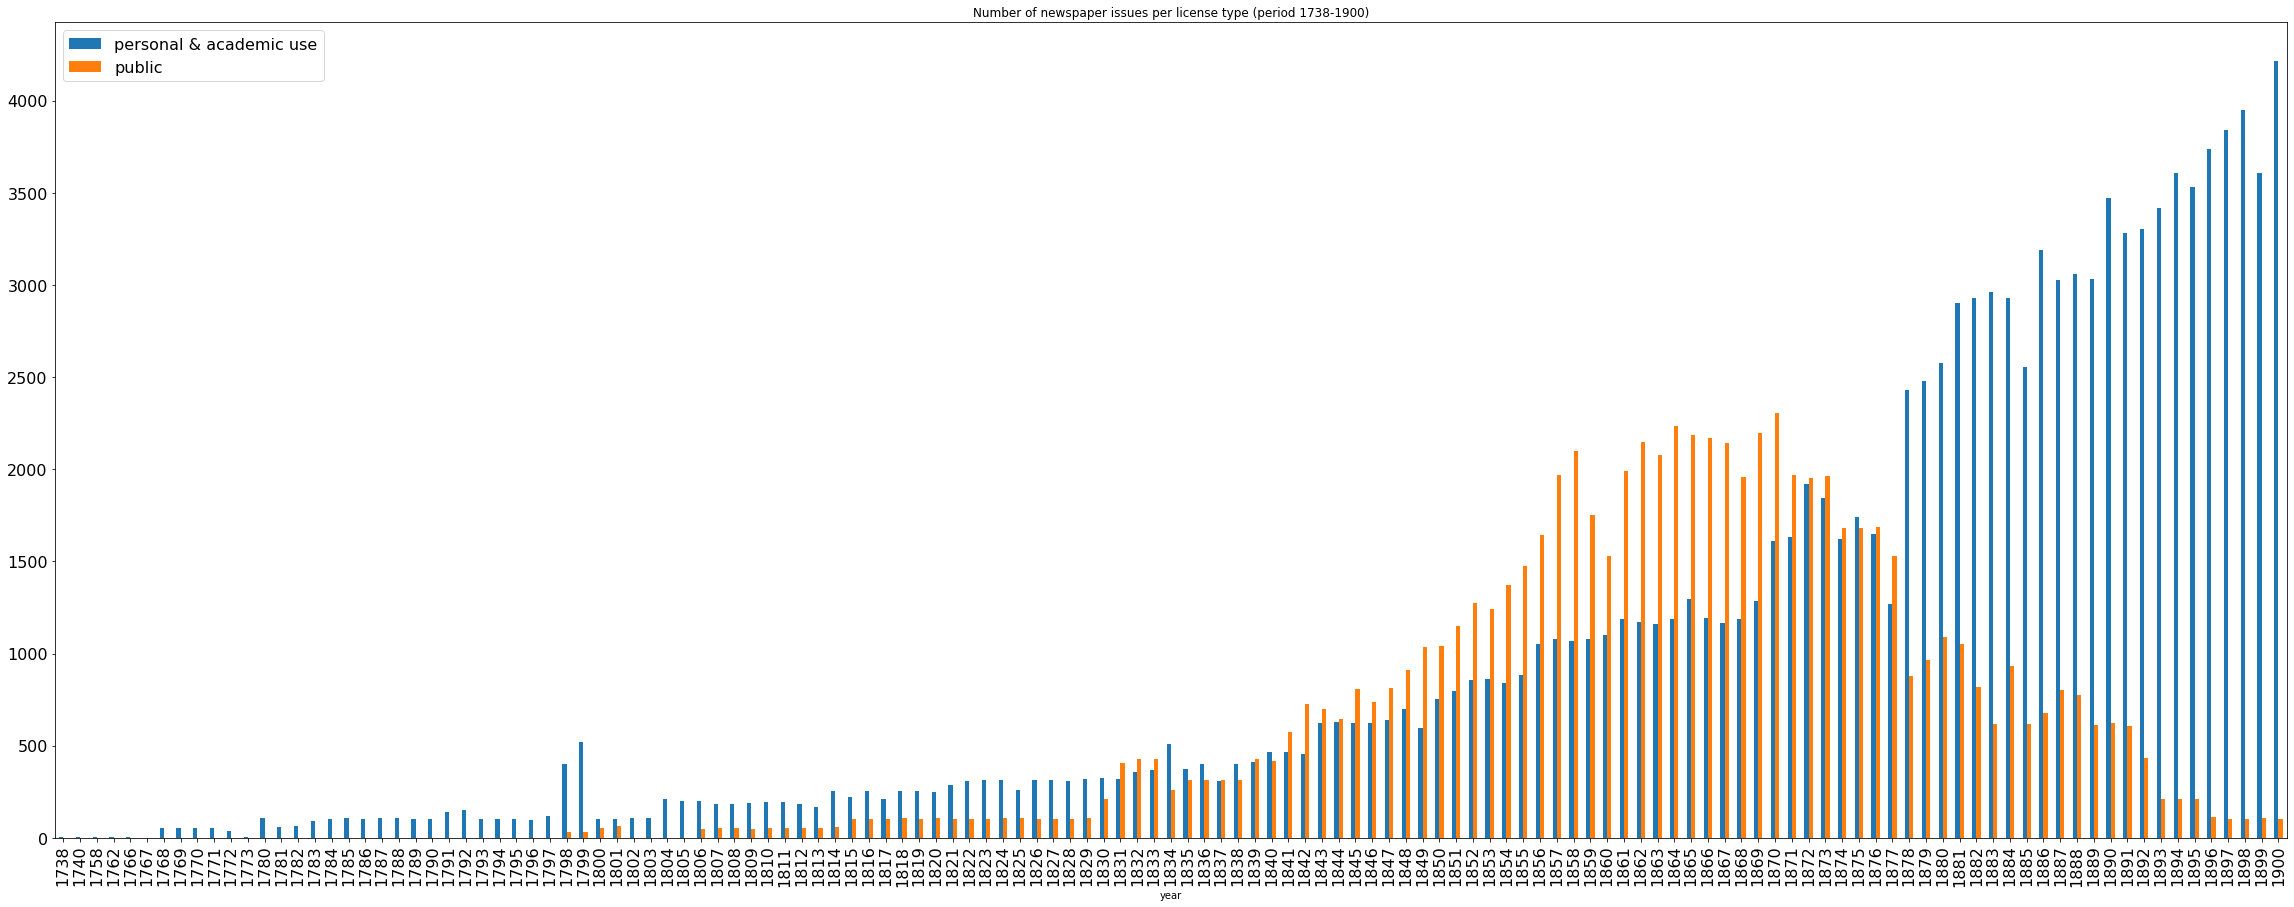

In [11]:
ax = df.loc[1738:1900].plot(
    kind='bar',
    figsize=(40,15),
    fontsize=16,
    title='Number of newspaper issues per license type (period 1738-1900)'
)

In [17]:
for item in ([ax.title]):
    item.set_fontsize(20)

In [18]:
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

In [19]:
ax.get_figure().savefig(
    '/home/romanell/Documents/impresso/impresso.github.io/assets/images/posts/pr-corpus-stats-plot1.png',
    dpi=300,
    bbox_inches='tight'
)

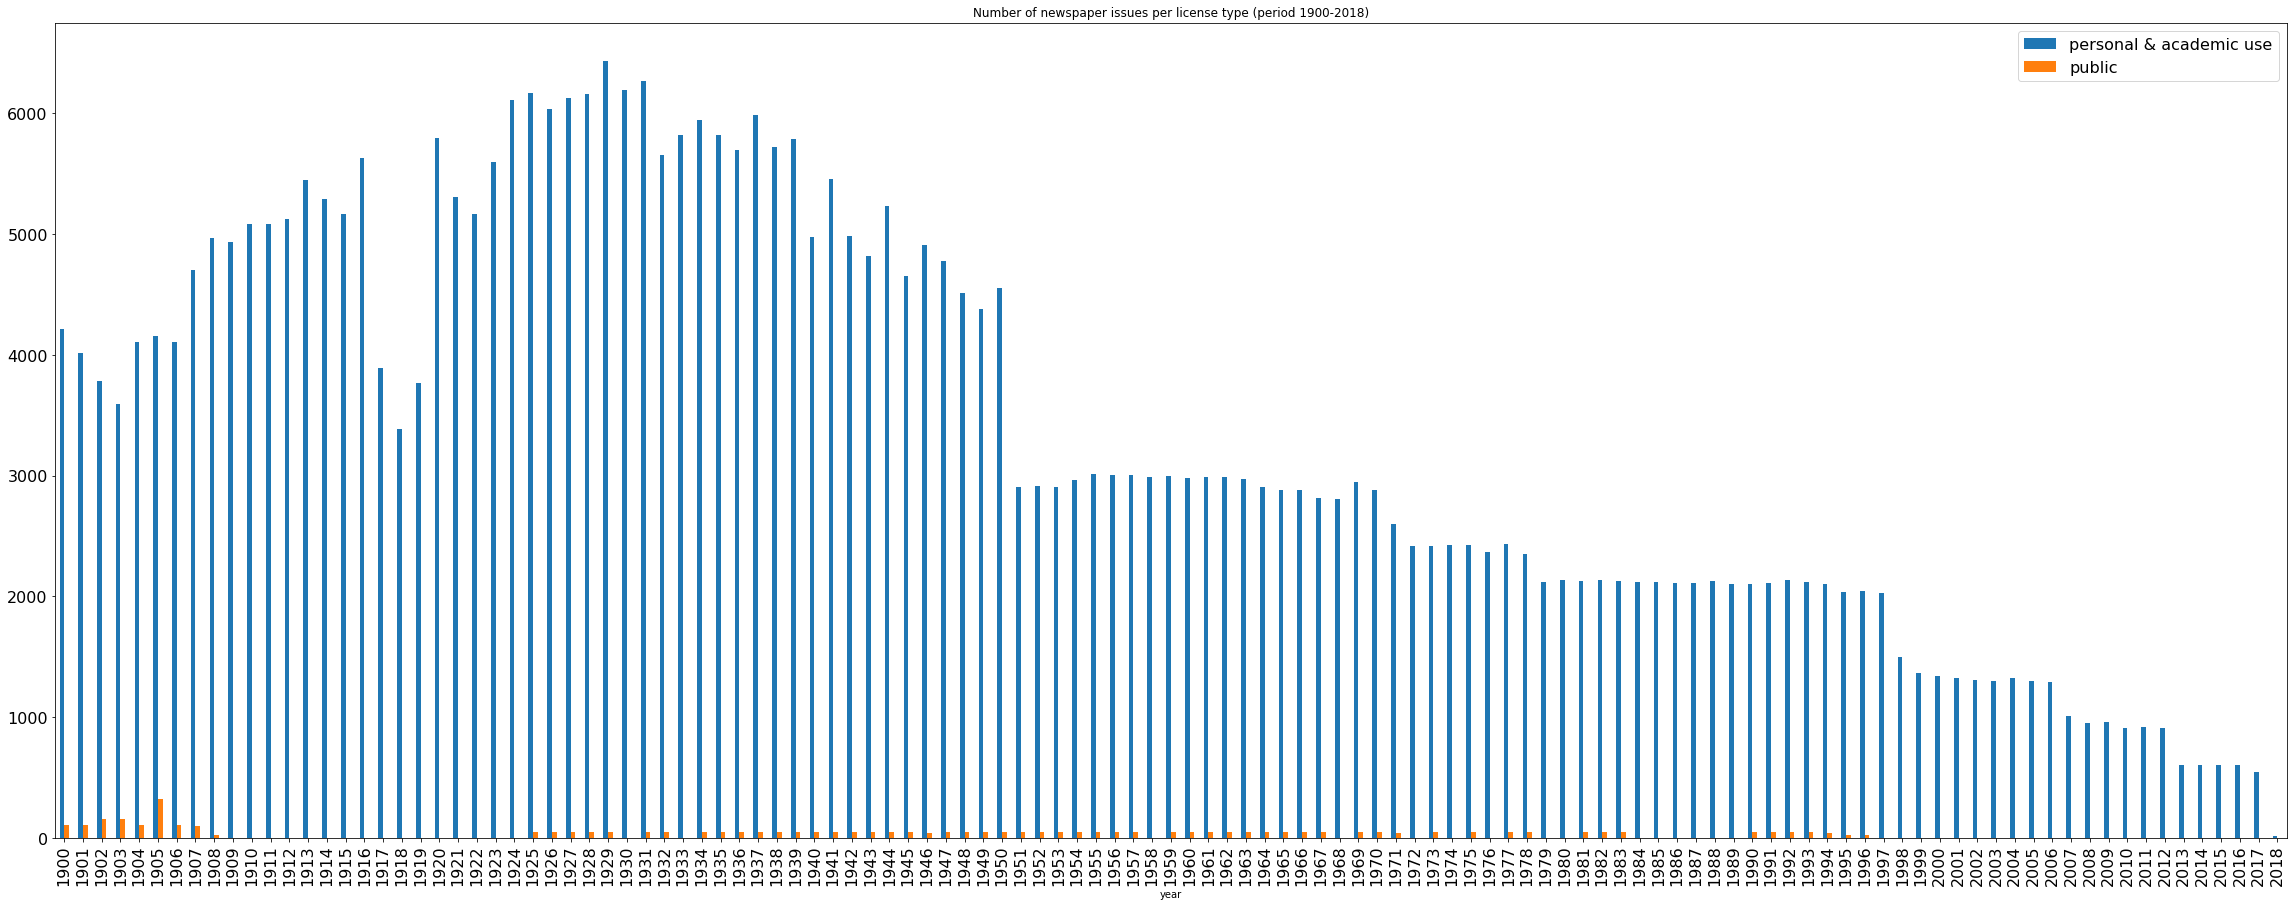

In [13]:
ax1 = df.loc[1900:].plot(
    kind='bar',
    figsize=(40,15),
    fontsize=16,
    title='Number of newspaper issues per license type (period 1900-2018)'
)

In [14]:
for item in ([ax1.title]):
    item.set_fontsize(20)

In [15]:
for item in ([ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(16)

In [16]:
ax1.get_figure().savefig(
    '/home/romanell/Documents/impresso/impresso.github.io/assets/images/posts/pr-corpus-stats-plot2.png',
    dpi=300,
    bbox_inches='tight'
)

## data inspection

In [185]:
dask_client

Client Scheduler: tcp://10.90.47.2:21981 Dashboard: http://10.90.47.2:8787/status,Cluster Workers: 50 Cores: 50 Memory: 500.00 GB


In [187]:
cluster.close()

In [168]:
from dask import dataframe as ddf
from dask import bag as db
from random import shuffle
from impresso_commons.utils.s3 import fixed_s3fs_glob, IMPRESSO_STORAGEOPT
import json

In [169]:
ci_df = ddf.read_csv(
    "s3://impresso-stats/content-item-stats/*",
    storage_options=IMPRESSO_STORAGEOPT
)

In [122]:
ci_df[ci_df.type=='ar'].n_tokens.describe().compute()

count          26,903,280.00
mean                  336.15
std                   496.00
min                     0.00
25%                    95.00
50%                   274.00
75%                 1,411.75
max                14,964.00
Name: n_tokens, dtype: float64

In [116]:
section_df = ci_df[ci_df.type=='section'].compute()

In [121]:
section_df.n_tokens.describe()

count              82,143.00
mean                1,258.24
std                 1,258.23
min                     0.00
25%                   386.00
50%                   874.00
75%                 1,771.00
max                19,083.00
Name: n_tokens, dtype: float64

In [137]:
from random import choice

In [151]:
sample_size = 10
sample = []
sampled_nps = []

for key, group in section_df.groupby(by='newspaper'):
    sampled_nps.append(key)
    ci_ids = list(group.id)
    shuffle(ci_ids)
    
    sample += [
        choice(ci_ids)
        for n in range(0, sample_size)
    ]

In [152]:
len(sample)

60

In [154]:
sampled_nps

['FCT', 'LLS', 'OIZ', 'SDT', 'SMZ', 'VHT']

In [160]:
rebuilt_bucket = "s3://canonical-rebuilt-release"

In [174]:
rebuilt_files = [
    file
    for newspaper in sampled_nps
    for file in fixed_s3fs_glob(f'{rebuilt_bucket}/{newspaper}/*.bz2')
]

In [171]:
sample[:10]

['FCT-1955-05-20-a-i0006',
 'FCT-1956-09-28-a-i0002',
 'FCT-1962-06-01-a-i0005',
 'FCT-1959-03-06-a-i0008',
 'FCT-1962-05-04-a-i0003',
 'FCT-1955-11-11-a-i0003',
 'FCT-1956-06-15-a-i0007',
 'FCT-1955-06-10-a-i0009',
 'FCT-1962-11-16-a-i0004',
 'FCT-1962-03-16-a-i0005']

In [175]:
rebuilt_files

['s3://canonical-rebuilt-release/FCT/FCT-1955.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1956.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1957.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1958.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1959.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1960.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1961.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1962.jsonl.bz2',
 's3://canonical-rebuilt-release/FCT/FCT-1963.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1906.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1907.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1908.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1909.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1910.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1911.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1912.jsonl.bz2',
 's3://canonical-rebuilt-release/LLS/LLS-1913.jsonl.bz2',
 's3://canonic

In [176]:
tmp = db.read_text(
    rebuilt_files,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads).filter(
    lambda ci: ci['id'] in sample and 'ft' in ci
).map(
    lambda ci: {"id": ci['id'], "fulltext": ci['ft']}
).to_dataframe().persist()

In [177]:
sample_df = tmp.compute()

In [181]:
sample_df.set_index('id', drop=False, inplace=True)

In [183]:
sample_df.to_csv('/home/romanell/Downloads/section_cis_sample.csv', encoding='utf-8')

In [184]:
sample_df.shape

(60, 2)